# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
### Hyperparameters and settings to try out:
# Gray images did not improve or hurt performance, but make the model smaller and therefore faster to train.
use_gray_images = True
# Saturation happends between 10 to 15 epochs most of the times.
EPOCHS = 20
BATCH_SIZE = 256
# Somehow it is impossible to improve performance with learning rate 000.5
learning_rate = 0.005
#Dropout of 0.75 improved by 2% the validation performance
dropout_keep_prob = 0.60

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle

# Point to saved training and testing data

training_file = 'traffic-signs-data/train.p'
validation_file= 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np

# Some data in the original validation set was very difficult to learn from the training data
# I opted to merge trainning data and validation data
# Since there is no dedicated validation set, we will use cross-validation to measure epoch
# progress and a lower dropout keep parameter to prevent overfitting.
X_train_np = np.concatenate((np.array(X_train), np.array(X_valid)))
X_test_np = np.array(X_test)
y_train_np = np.concatenate((np.array(y_train), np.array(y_valid)))
y_test_np = np.array(y_test)

# Number of training examples
n_train = len(X_train)

# Number of original validation examples
n_valid = len(X_valid)

# Number of testing examples.
n_test = X_test_np.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train_np.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [4]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline


import matplotlib.gridspec as gridspec
import math
import random


# image ploting code from here: 
# https://github.com/swirlingsand/self-driving-car-nanodegree-nd013/blob/master/CarND-Traffic-Sign-Classifier-Project-master/Traffic_Sign_Classifier.ipynb
def rand_image_gen(x_set, n_images_to_gen, randomize = True):
    for index in range(n_images_to_gen):
        random_index =random.randint(0,len(x_set)-1)
        if randomize:
            yield x_set[random_index]
        else:
            yield x_set[index]

def print_a_line_of_images(Images, num, randomize = True):
    # graphing function concepts from http://navoshta.com/traffic-signs-classification/
    fig = plt.figure(figsize = (num, 1))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

    for i, im in enumerate(rand_image_gen(Images, num, randomize = randomize)):
        axis = fig.add_subplot(1, num, i + 1, xticks=[], yticks=[])
        axis.imshow(im)
    plt.show()
#print_a_line_of_images(X_train, 10)

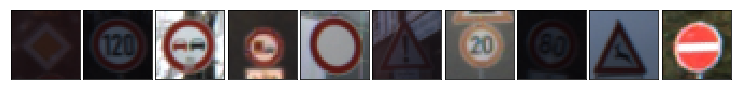

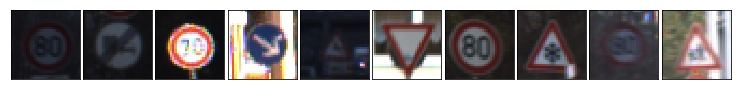

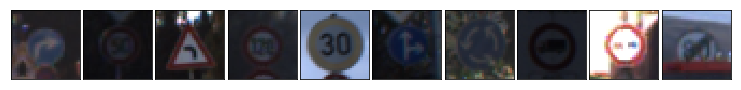

In [5]:
#Show random images
num_cols = 10
num_rows = 3

for i in range(num_rows):
    print_a_line_of_images(X_train, num_cols)




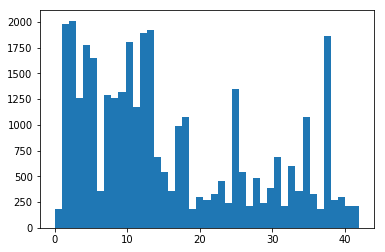

In [6]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline


import matplotlib.gridspec as gridspec
import math
import random

set_to_analyze = y_train

plt.hist(set_to_analyze, n_classes)
plt.show()


#Data is clearly not balanced.

34799
27 :  210
28 :  480
30 :  390


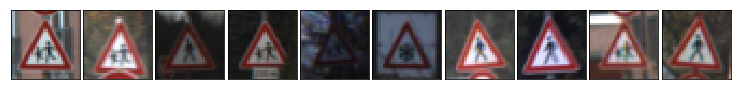

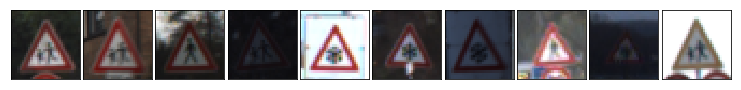

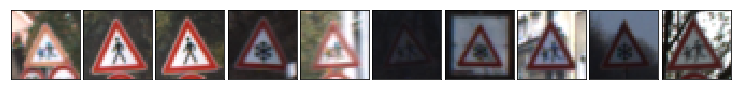

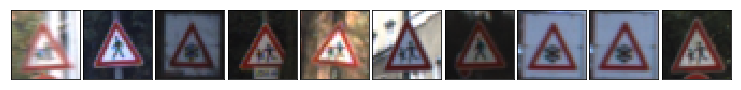

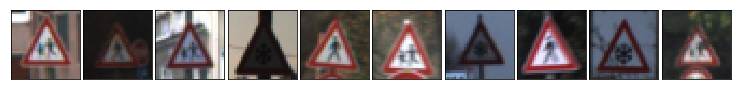

In [104]:
#Show random images
num_cols = 10
num_rows = 5

# The original validation dataset had some difficult tags, which where always causing problems. 
# I opted to include those in training and change to cross-validation.
# See,s lke x-validation with dropout improved performance, and made errors more random.
#difficult_labels = tuple(set([2,25]))

# New errors:
#difficult_labels = tuple(set([11, 7, 5, 0, 3, 8, 2, 2, 27, 4, 3, 1, 1, 0, 0,10, 11]))
difficult_labels = tuple(set([28, 30, 27]))


difficult_slice = [label in difficult_labels for label in y_train]
y_difficult = y_train[difficult_slice]
X_difficult = X_train[difficult_slice]

print(len(difficult_slice))


hist, bins = np.histogram(set_to_analyze, range(n_classes))
for label in difficult_labels:
    print(label, ": ", hist[label])


for i in range(num_rows):
    print_a_line_of_images(X_difficult, num_cols)


## ----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [8]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.

from sklearn.utils import shuffle
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

gray_image_shape = image_shape[0:2] + (1,)

def min_max_scale(instance):
    x_min = 0
    x_max = 255
    a, b = 0.0, 1.0
    conversion_factor = (b - a)/(x_max - x_min)    
    return np.add(a,np.multiply(np.subtract(instance,x_min), conversion_factor))

def pre_process(x_in, y_in):
    x_out = []
    y_out = y_in
    for instance in x_in:
        if use_gray_images:
            gray_instance = cv2.cvtColor(instance, cv2.COLOR_RGB2GRAY).reshape(gray_image_shape)
            instance = gray_instance
            
        eq_instance = cv2.equalizeHist(instance).reshape(instance.shape)
        x_out.append(min_max_scale(eq_instance))
    
    return np.array(x_out), y_out

if use_gray_images:
    image_shape = gray_image_shape
X_train_pp, y_train_pp = pre_process(X_train_np, y_train_np)
X_test_pp, y_test_pp = pre_process(X_test_np, y_test_np)

print(image_shape)
print("Done pre-processing")

(32, 32, 1)
Done pre-processing


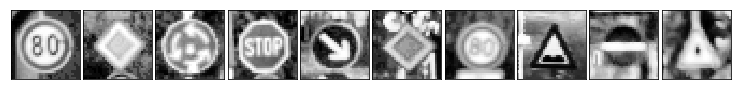

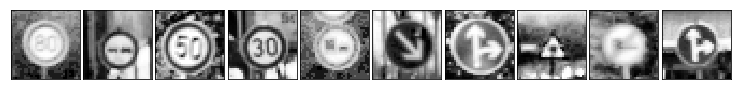

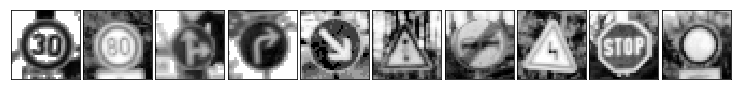

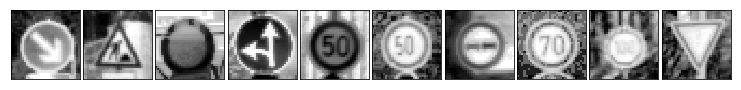

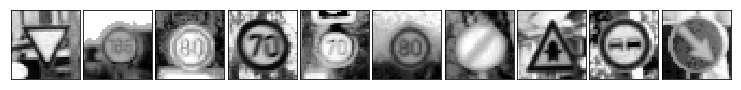

In [37]:
#Show random images after pre-processing
num_cols = 10
num_rows = 5

def print_a_line_of_pp_images(images, num, randomize = True):
    # graphing function concepts from http://navoshta.com/traffic-signs-classification/
    fig = plt.figure(figsize = (num, 1))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

    for i, im in enumerate(rand_image_gen(images, num, randomize = randomize)):
        axis = fig.add_subplot(1, num, i + 1, xticks=[], yticks=[])
        axis.imshow(im.reshape(im.shape[0:2]), cmap = 'gray')
    plt.show()

for i in range(num_rows):
    print_a_line_of_pp_images(X_train_pp, num_cols)

### Model Architecture

In [10]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
from tensorflow.contrib.layers import flatten


def LeNet(x, keep_prob):   
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    #Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6. changed depth to 10 to see if more feautres
    #  can cope with a lower keep setting for dropout, which prvents overfitting on cross-validation.
    input_depth1 = image_shape[2]
    output_depth1 = 16
    
    #Stride can't be > 1 because we want output_size to be greater than >16 and we don't want too much padding.
    stride_conv = 1
    strides_conv = (1, stride_conv, stride_conv, 1)
    
    # Patch size calculated as output_size - input-size + 1
    patch_size1 = 5
    
    F_W1 = tf.Variable(tf.truncated_normal(
                                           (patch_size1, patch_size1, input_depth1, output_depth1),
                                           mean=mu,
                                           stddev=sigma)
                      )
    F_b1 = tf.Variable(tf.zeros(output_depth1))
    
    # The output size is reduced by using padding = VALID.
    padding = 'VALID'
    
    #Define conv net with biasess
    conv1 = tf.nn.conv2d(x, F_W1, strides_conv, padding) + F_b1
    
    # Activation + Dropout
    activ1 = tf.nn.dropout(tf.nn.relu(conv1), keep_prob)
    

    # Pooling. Input = 28x28x16. Output = 14x14x16.
    stride_pool_1 = 2
    pool1 = tf.nn.max_pool(
                                activ1,
                                ksize=[1, stride_pool_1, stride_pool_1, 1],
                                strides=[1, stride_pool_1, stride_pool_1, 1],
                                padding = padding)
    # Layer 2: Convolutional. Output = 10x10x32.
    input_depth2 = output_depth1
    output_depth2 = 32
        
    # Patch size calculated as output_size - input-size + 1
    patch_size2 = 5
    
    F_W2 = tf.Variable(tf.truncated_normal(
                                           (patch_size2, patch_size2, input_depth2, output_depth2),
                                           mean=mu,
                                           stddev=sigma)
                      )
    F_b2 = tf.Variable(tf.zeros(output_depth2))
    
    # The output size is reduced by using padding = VALID.
    
    #Define conv net with biasess
    conv2 = tf.nn.conv2d(pool1, F_W2, strides_conv, padding) + F_b2

    # Activation.
    activ2 = tf.nn.dropout(tf.nn.relu(conv2), keep_prob)

    # Pooling. Input = 10x10x16. Output = 5x5x32.
    stride_pool_2 = 2
    pool2 = tf.nn.max_pool(
                                activ2,
                                ksize=[1, stride_pool_2, stride_pool_2, 1],
                                strides=[1, stride_pool_2, stride_pool_2, 1],
                                padding = padding)

    
    # Flatten. Input = 5x5x32. Output = 800.
    #flat_conv_2_out = tf.reshape(pool2, shape = [-1,400])
    flat_conv_2_out = flatten(pool2
    
    # Layer 3: Fully Connected. Input = 800. Output = 120.
    input_depth3 = output_depth2 * patch_size2 * patch_size2
    output_depth3 = 120
    F_W3 = tf.Variable(tf.truncated_normal(
                                           (input_depth3, output_depth3),
                                           mean=mu,
                                           stddev=sigma)
                      )
    F_b3 = tf.Variable(tf.zeros(output_depth3))
    
    full3 = tf.add(tf.matmul(flat_conv_2_out, F_W3), F_b3)
    
    # Activation.
    activ3 = tf.nn.dropout(tf.nn.relu(full3), keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    input_depth4 = output_depth3
    output_depth4 = 84
    F_W4 = tf.Variable(tf.truncated_normal(
                                           (input_depth4, output_depth4),
                                           mean=mu,
                                           stddev=sigma)
                      )
    F_b4 = tf.Variable(tf.zeros(output_depth4))
    
    full4 = tf.add(tf.matmul(activ3, F_W4), F_b4)
    
    
    # Activation.
    activ4 = tf.nn.dropout(tf.nn.relu(full4), keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    input_depth5 = output_depth4
    output_depth5 = n_classes
    F_W5 = tf.Variable(tf.truncated_normal(
                                           (input_depth5, output_depth5),
                                           mean=mu,
                                           stddev=sigma)
                      )
    F_b5 = tf.Variable(tf.zeros(output_depth5))
    
    full5 = tf.add(tf.matmul(activ4, F_W5), F_b5)
    
    logits = full5
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [11]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from sklearn.model_selection import train_test_split

prediction_out = None

x = tf.placeholder(tf.float32, (None,) + image_shape)
y = tf.placeholder(tf.int32, (None))
keep = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

logits = LeNet(x, keep)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
incorrect_prediction = tf.logical_not(correct_prediction)
wrong_tags = tf.boolean_mask(y, tf.reshape(incorrect_prediction, shape = [-1]))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy, tags_not_detected = sess.run((accuracy_operation, wrong_tags), feed_dict={x: batch_x, y: batch_y, keep: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    print("tags_not_detected:", tags_not_detected)

    return total_accuracy / num_examples


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_pp, y_train_pp = shuffle(X_train_pp, y_train_pp)
        X_xval_train, X_xval_valid, y_xval_train, y_xval_valid = train_test_split(X_train_pp, y_train_pp, test_size=0.20, random_state=i)
        num_examples = len(X_xval_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_xval_train[offset:end], y_xval_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep: dropout_keep_prob})
            
        validation_accuracy = evaluate(X_xval_valid, y_xval_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")  


Training...

tags_not_detected: [40  2  8  7  3  7  2  2  7  4 34  3  7  0  2 17  7  2  3 29  4 25 29 21  0
 19  0 26  2  7 23 24  2  4 24 12  4 15  2 40  4 30 28 21  2 23 24]
EPOCH 1 ...
Validation Accuracy = 0.663

tags_not_detected: [ 1  3  2  3  7 27 30 28  3  6  3  3 41 29 15 29  7  7  2  2 21 15  3 29  3
 31 19  3 11 41]
EPOCH 2 ...
Validation Accuracy = 0.829

tags_not_detected: [ 3  4  7 21  3  2  3  1 10  2]
EPOCH 3 ...
Validation Accuracy = 0.893

tags_not_detected: [ 5  2  0 24 19  2  1  1 19  3  5 21  0 19  0  0  8]
EPOCH 4 ...
Validation Accuracy = 0.913

tags_not_detected: [21  7  1  4  7  4  2 29  0  1]
EPOCH 5 ...
Validation Accuracy = 0.925

tags_not_detected: [31 23 10  2  8 18 30]
EPOCH 6 ...
Validation Accuracy = 0.941

tags_not_detected: [27 26 15 10 39 41]
EPOCH 7 ...
Validation Accuracy = 0.961

tags_not_detected: [25  7 10  2  2  1]
EPOCH 8 ...
Validation Accuracy = 0.957

tags_not_detected: [ 7  1 26  7 19 19]
EPOCH 9 ...
Validation Accuracy = 0.959

tags_not_d

In [12]:
# Run the testing set

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_pp, y_test_pp)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

tags_not_detected: [ 5 30 11 18  0 18  6]
Test Accuracy = 0.919


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

17.jpg
28.jpg
18.jpg
1.jpg
38.jpg


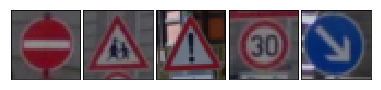

In [14]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

#I cropped images from google. they are squared, but not 32 by 32, so they need some resizing.
from  scipy import misc
from PIL import Image
import os
num_cols = 5

X_new = []
y_new = []
new_image_dir = "new_images"
for i, image_path in enumerate(os.listdir(new_image_dir)):
    print(image_path)
    label = int(image_path.split(".")[0])
    y_new.append(label)
    new_image = misc.imread("new_images" + "/" + image_path)
    thumbnail = misc.imresize(new_image, (32,32,3))
    X_new.append(thumbnail)
X_new = np.array(X_new)
y_new = np.array(y_new)


print_a_line_of_images(X_new, num_cols, randomize = False)



### Predict the Sign Type for Each Image

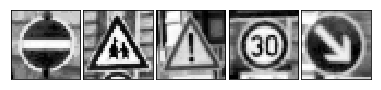

[17 28 18  1 38]


In [16]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

#Pre-process
num_cols = 5
X_new_pp, y_new_pp = pre_process(X_new, y_new)

print_a_line_of_pp_images(X_new_pp, num_cols, randomize = False)
print(y_new_pp)


In [18]:
# Evaluate the model on new images
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_new_pp, y_new_pp)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

tags_not_detected: []
Test Accuracy = 1.000


### Analyze Performance

In [38]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

# Evaluate the model on new images
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy, tags_not_detected = sess.run((accuracy_operation, wrong_tags), feed_dict={x: X_new_pp, y: y_new_pp, keep: 1.0})
    print("logits Accuracy = {:.3f}".format(test_accuracy))
    prediction_accuracy = int((5 - len(tags_not_detected)) / 5 * 100) 
    print("Prediction accuracy: {:d} % ".format(prediction_accuracy))




logits Accuracy = 1.000
Prediction accuracy: 100 % 


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [102]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
class_dict = {}
with open('./signnames.csv', 'r') as classes_f:
    lines = classes_f.readlines()
    lines.pop(0)
    for line in lines:
        line = line.split('\n')[0]
        class_id, class_text = line.split(',')
        class_dict[int(class_id)] = class_text


probs = tf.nn.softmax(logits)
top_k_out = tf.nn.top_k(probs, k=5)

def print_table(top_5_prob, top_5_classes, class_dictionary):
    print("| Probability | Prediction | \n|" + (":" + 21 * '-' + ":|") *2)#

    for prob, y_class in zip(top_5_prob, top_5_classes):
        
        print("| {:.3f} | {:s} |".format(float(prob), class_dictionary[y_class]))
    
def print_predictions(images, predictions, class_dictionary):
    print("| Image | Prediction | \n|" + (":" + 21 * '-' + ":|") *2)#

    for image, prediction in zip(images, predictions):
        
        print("| {:s} | {:s} |".format(class_dictionary[image], class_dictionary[prediction]))
        


# Evaluate the model on new images
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top_prob  = sess.run(top_k_out, feed_dict={x: X_new_pp, y: y_new_pp, keep: 1.0})
predictions = []  
for top_5_p, top_5_class, y_correct in zip(top_prob.values, top_prob.indices, y_new_pp):
    print_table(top_5_p, top_5_class, class_dict)
    predictions.append(top_5_class[0])
    print("\n")

print_predictions(y_new_pp, predictions, class_dict)    

| Probability | Prediction | 
|:---------------------:|:---------------------:|
| 1.000 | No entry |
| 0.000 | Stop |
| 0.000 | Roundabout mandatory |
| 0.000 | Keep right |
| 0.000 | Turn left ahead |


| Probability | Prediction | 
|:---------------------:|:---------------------:|
| 0.216 | Children crossing |
| 0.163 | Beware of ice/snow |
| 0.113 | Pedestrians |
| 0.093 | Dangerous curve to the right |
| 0.071 | Bicycles crossing |


| Probability | Prediction | 
|:---------------------:|:---------------------:|
| 0.981 | General caution |
| 0.011 | Pedestrians |
| 0.007 | Traffic signals |
| 0.000 | Dangerous curve to the right |
| 0.000 | Road narrows on the right |


| Probability | Prediction | 
|:---------------------:|:---------------------:|
| 1.000 | Speed limit (30km/h) |
| 0.000 | Speed limit (20km/h) |
| 0.000 | Speed limit (50km/h) |
| 0.000 | Speed limit (70km/h) |
| 0.000 | Speed limit (80km/h) |


| Probability | Prediction | 
|:---------------------:|:--------------

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 